# Optimal portfolio frontier

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sc
import dataframe_image as dfi
from scipy.stats import norm
from pypfopt.risk_models import exp_cov, cov_to_corr, semicovariance, CovarianceShrinkage

In [2]:
sns.set_theme(style='darkgrid')

In [3]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'AXGICCH LX Equity',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'GSMBIAS LX Equity',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    'HYBRIDCHF': 'NBCHCPA ID Equity',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'SWBHCHP LX Equity',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'SGCIFCH LX equity',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    'JPGCHFCP Index': 'CSIFMFH SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'AURLNCHF Curncy': 'AURLNCHF CURNCY',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index',
    'SBWG10CH INDEX': 'ZKWXBHN SW Equity',
    'SBWGNSUU Index': 'IGLO LN Equity',
    'JHCC1R10 Index': 'X03H SW Equity',
    'M7CXSSD Index' : 'IJPC SW Equity'
    }, inplace=True)

    return portfolio

In [4]:
def sigma_to_sharp (weights, annual_returns, annual_cov):
    
    port_ret = weights @ annual_returns
    port_vol = np.sqrt(weights.T @ annual_cov @ weights )
    if port_vol == 0:
        port_sharp = 0
    else:
        port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

In [5]:
def portfolioReturn(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[0]

In [6]:
def portfolioVariance(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[1]

In [7]:
def portfolioSharpe(weights, annual_returns, annual_cov):
    return -sigma_to_sharp(weights, annual_returns, annual_cov)[2]

In [8]:
def efficientOpt(x0, annual_returns, annual_cov, ret, A, a_inf, a_sup, B, b_inf, b_sup, bounds):
    num_assets = len(annual_returns)
    args = (annual_returns, annual_cov)

    constraints = ({'type':'ineq', 'fun': lambda x: portfolioReturn(x, annual_returns, annual_cov) - ret},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: A @ x - a_inf},
                   {'type': 'ineq', 'fun': lambda x: - A @ x + a_sup},
                   {'type': 'ineq', 'fun': lambda x: B @ x - b_inf},
                   {'type': 'ineq', 'fun': lambda x: - B @ x + b_sup},
                  )
    
    effOpt = sc.minimize(portfolioVariance, x0=x0, args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

In [9]:
def min_variance_opti(annual_returns, annual_cov):
    
    num_assets = len(annual_returns)
    args = (annual_returns, annual_cov)
    x0 = np.ones(num_assets) / num_assets
    
    constraints =  (#{'type':'ineq', 'fun': lambda x: portfolioReturn(x, annual_returns, annual_cov) - ret},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                  )
    
    effOpt = sc.minimize(portfolioVariance, x0=x0, args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

In [10]:
def max_sharpe_opti(annual_returns, annual_cov):
    
    num_assets = len(annual_returns)
    args = (annual_returns, annual_cov)
    x0 = np.ones(num_assets) / num_assets
    
    constraints =  (#{'type':'ineq', 'fun': lambda x: portfolioReturn(x, annual_returns, annual_cov) - ret},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                  )
    
    effOpt = sc.minimize(portfolioSharpe, x0=x0, args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

# Optimisation

In [11]:
data_excel = pd.read_excel('data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates'])

In [12]:
list_isin = ['SBWMSF3L Index', 'SBF14T Index', 'SBWGNSZC Index', 
             'LG30TRCH Index','H00014CH Index', 'UCBIFX28 Index', 
             'SPI Index', 'MXWO Index', 'NDUEEGF Index', 'HFRXGLC Index',
             'SWIIT Index', 'XAU Curncy']
df_list_isin = pd.DataFrame(list_isin, columns=['No ISIN'])
list_isin = list(port_filter(df_list_isin)['No ISIN'])
list_nom = ['Cash CHF','Obl. Suisse','Obl. Monde',
            'Obl. HY', 'Obl. EM', 'Obl. Convertible','Actions Suisse','Actions Monde','Actions EM','Hedge Fund',
            'Real Estate','Or']
ticker_nom = pd.DataFrame(data=zip(list_isin, list_nom), columns=['ticker', 'nom'])

In [13]:
list_saa = [0.05, 0.23, 0.075, 0.015, 0.015, 0.015, 0.189, 0.227, 0.064, 0.06, 0.03, 0.03]

In [14]:
saa = pd.DataFrame(zip(list_isin, list_saa), columns=['Ticker', 'weight'])
saa

,Ticker,weight
0,SBWMSF3L Index,0.050
1,SBF14T Index,0.230
2,SBWGNSZC Index,0.075
3,H00039CH Index,0.015
4,H00014CH Index,0.015
5,SWBHCHP LX Equity,0.015
6,SPI Index,0.189
7,MXWO Index,0.227
8,NDUEEGF Index,0.064
9,HFRXGLC Index,0.060


In [15]:
data = data_excel.copy().fillna(method='ffill')#.loc['2010-01-01':]
data = data[list_isin]
data.columns = list_nom
num_assets_data = data.shape[1]

daily_returns = data.pct_change()
daily_returns.columns = list_nom
annual_returns_histo = ((1 + daily_returns.mean())**252 - 1).values
daily_cov = daily_returns.cov()
annual_cov_histo = daily_cov.values * 252

In [32]:
(daily_returns.std() * np.sqrt(252) * 100).round(2)

Cash CHF             0.07
Obl. Suisse          0.82
Obl. Monde           2.32
Obl. HY              4.12
Obl. EM              3.98
Obl. Convertible     5.56
Actions Suisse      13.68
Actions Monde       13.82
Actions EM          16.23
Hedge Fund           3.20
Real Estate          7.27
Or                  14.69
dtype: float64

In [16]:
data.head()

,Cash CHF,Obl. Suisse,Obl. Monde,Obl. HY,Obl. EM,Obl. Convertible,Actions Suisse,Actions Monde,Actions EM,Hedge Fund,Real Estate,Or
Dates,,,,,,,,,,,,
2005-01-02,111.0245,NaN,345.97,152.9744,202.5721,NaN,4234.56,1169.34,178.759,NaN,188.29,438.05
2005-01-03,111.0305,NaN,346.02,152.9744,202.7449,NaN,4289.16,1161.54,178.835,NaN,189.17,428.54
2005-01-04,111.0324,NaN,346.11,152.9744,201.7342,NaN,4294.56,1148.84,175.767,NaN,189.38,427.75
2005-01-05,111.0344,NaN,346.15,152.9744,200.7401,NaN,4259.73,1142.25,173.231,NaN,189.97,426.44
2005-01-06,111.0364,NaN,346.54,152.9744,200.5667,NaN,4271.48,1142.09,170.944,NaN,190.50,422.06


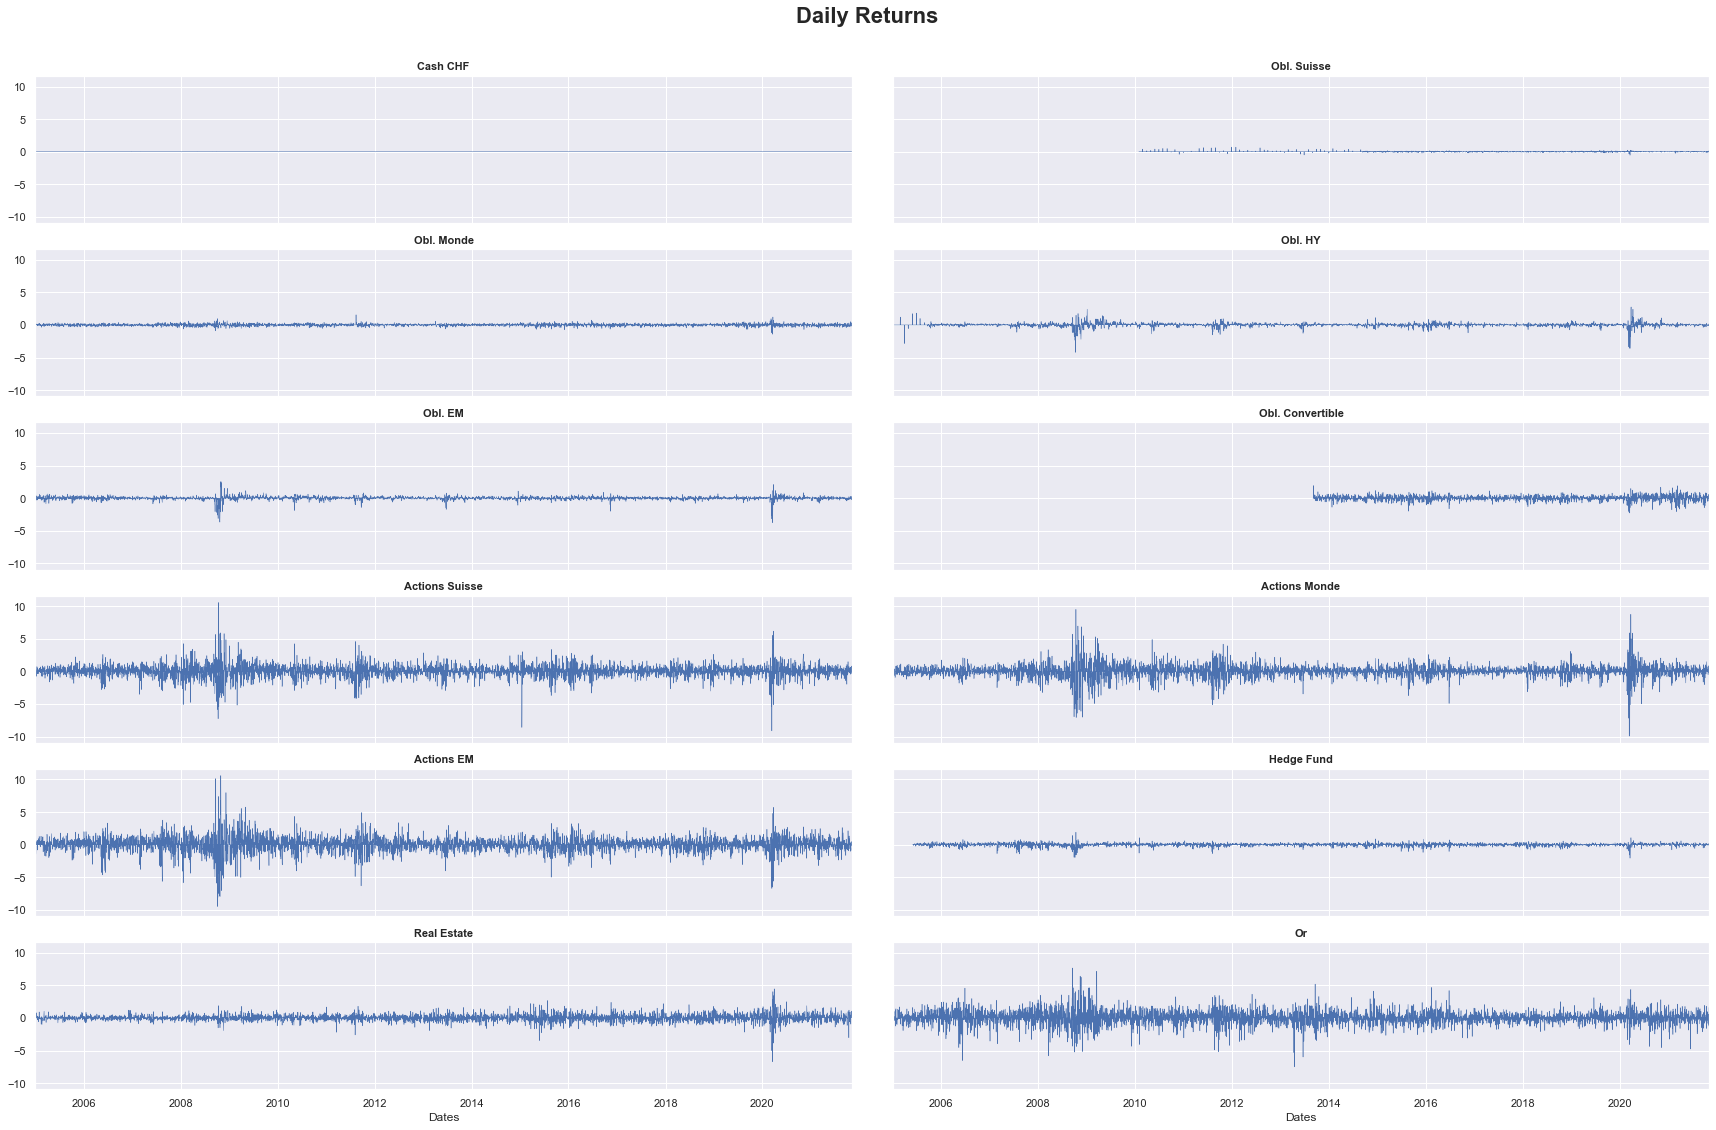

In [17]:
fig, axs = plt.subplots(6, 2, figsize=(24,16), sharex=True, sharey=True)
for i, col in enumerate(data.columns):
    axs = axs.ravel()
    (data[col].dropna().pct_change() * 100).plot(lw=0.5, ax=axs[i])
    axs[i].grid(visible=True)
    axs[i].set_title(col, fontweight='bold', fontsize=11)

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, top=0.92)
fig.suptitle('Daily Returns', fontsize=22, fontweight='bold', x=0.505)
plt.savefig('output/opti/daily_returns.png', dpi=200, bbox_inches='tight')
plt.show()

In [18]:
data_histo = np.vstack((annual_returns_histo * 100, 
                       (daily_returns.std() * np.sqrt(252) * 100).values, 
                       (np.fmin(daily_returns, 0).std() * np.sqrt(252) * 100).values))

df_data_histo = pd.DataFrame(data=data_histo, columns=list_nom, index=['Annualized average Return (%)', 'Annualized Std. (%)', 'Annualized Semi Std. (%)']).round(2)


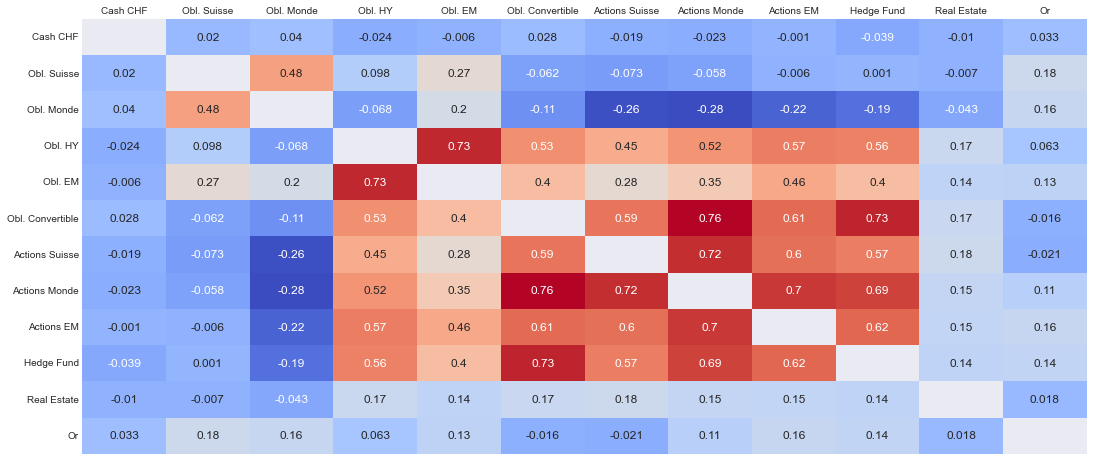

In [19]:
corr = daily_returns.corr().round(3)

fig, ax = plt.subplots(figsize=(18,8))

mask = np.identity(12)
sns.heatmap(data=corr, annot=True, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))

ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,labeltop=True, length=0)
plt.savefig('output/opti/correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
df_scenarios = pd.read_excel('data/scenarios.xlsx', sheet_name='scenarios2')
df_scenarios.rename(columns={'Ticker': 'No ISIN'}, inplace=True)
df_scenarios = port_filter(df_scenarios)
df_scenarios.index = df_scenarios['No ISIN']
df_scenarios.drop(columns='No ISIN', inplace=True)
df_scenarios.reindex(list_isin)
df_scenarios.index = list_nom
df_scenarios.index.name = None
df_scenarios['Historique'] = annual_returns_histo
df_scenarios = df_scenarios[['Historique', 1, 2, 3, 4, 'Pondéré']]

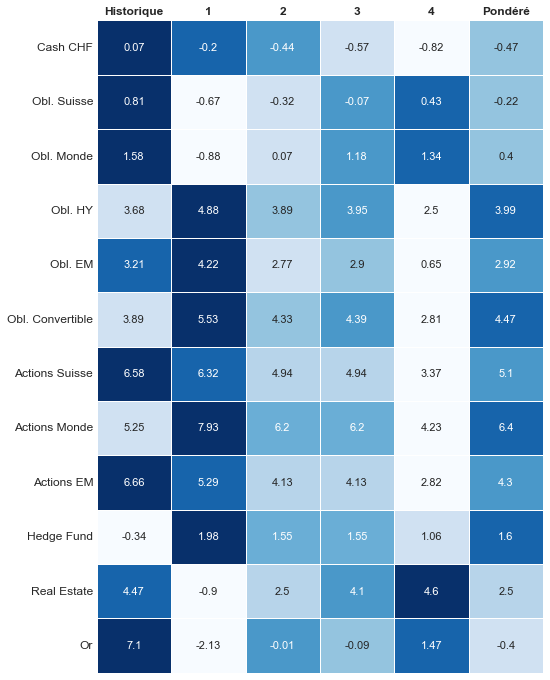

In [21]:
fig, ax = plt.subplots(figsize=(8,12))
sns.heatmap(data=df_scenarios.rank(axis=1), annot=(df_scenarios * 100).round(2), cmap='Blues', cbar=False, linewidth=1, annot_kws=dict(size=11), fmt='.3g')
ax.tick_params(axis='both', which='major', labelsize=12, labelbottom=False, labeltop=True, labelrotation=0, length=0)
ax.set_xticklabels(ax.get_xticklabels(), weight='bold')
plt.savefig('output/opti/scenarios.png', dpi=300, bbox_inches = "tight")
plt.show()

In [22]:
A = np.array([[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]])

B = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

a_inf = np.array([0.015, 0.42])
a_sup = np.array([0.075, 0.54])

b_inf = np.array([0.049, 0.15, 0., 0.139, 0.177, 0.014, 0.03, 0., 0.])
b_sup = np.array([0.051, 0.40, 0.15, 0.239, 0.277, 0.114, 0.09, 0.06, 0.06])

In [23]:
bounds = [
    (0.0499, 0.0501),
    (0.15, 0.40),
    (0., 0.15),
    (0., 1.),
    (0., 1.),
    (0., 1.),
    (0.139, 0.239),
    (0.177, 0.277),
    (0.014, 0.114),
    (0.03, 0.09),
    (0., 0.06),
    (0., 0.06)
]

 58%|█████▊    | 58/100 [00:02<00:02, 14.11it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 22.92it/s]


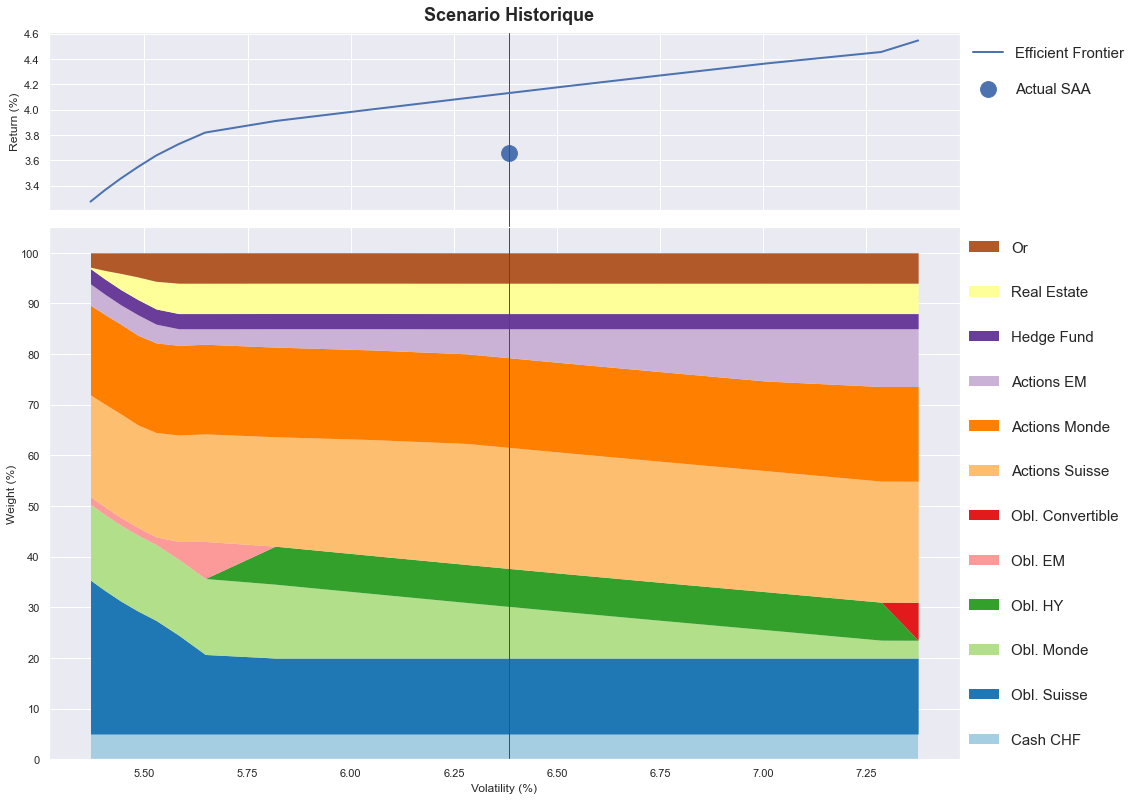

 23%|██▎       | 23/100 [00:00<00:01, 72.14it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:03<00:00, 29.10it/s]


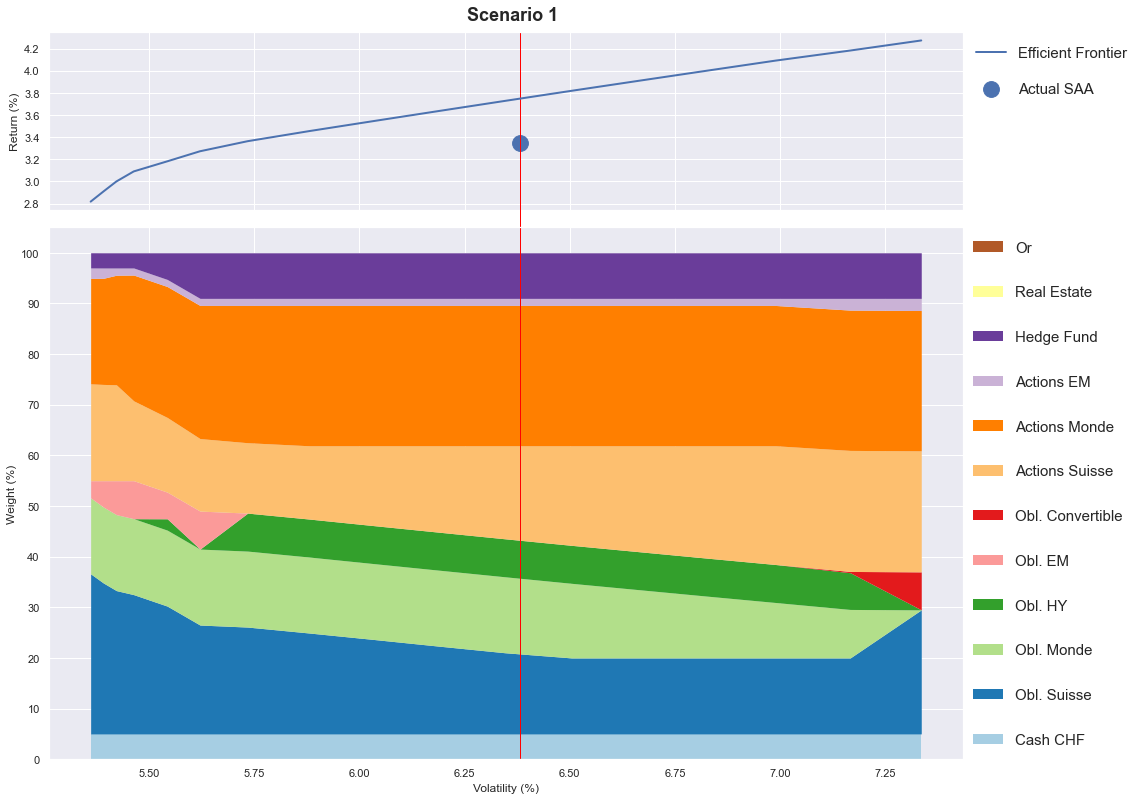

 21%|██        | 21/100 [00:00<00:01, 65.83it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


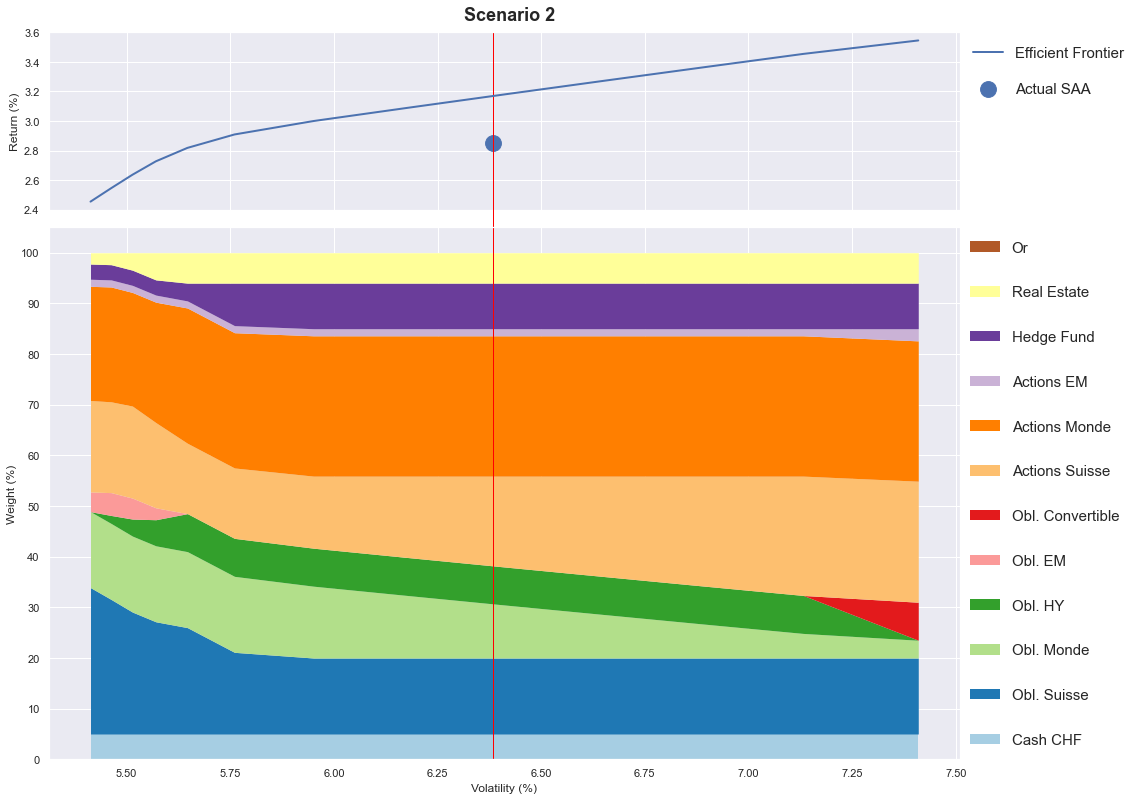

 22%|██▏       | 22/100 [00:00<00:01, 70.74it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:03<00:00, 26.51it/s]


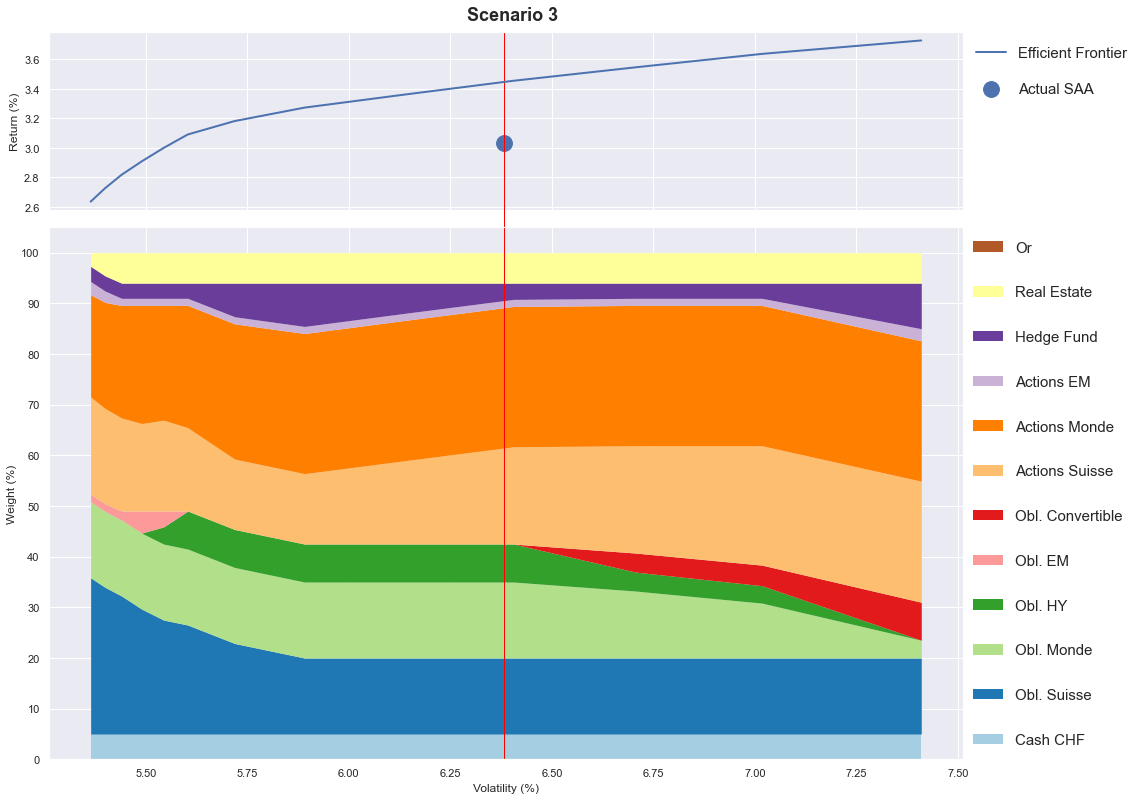

 15%|█▌        | 15/100 [00:00<00:01, 69.10it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 22.73it/s]


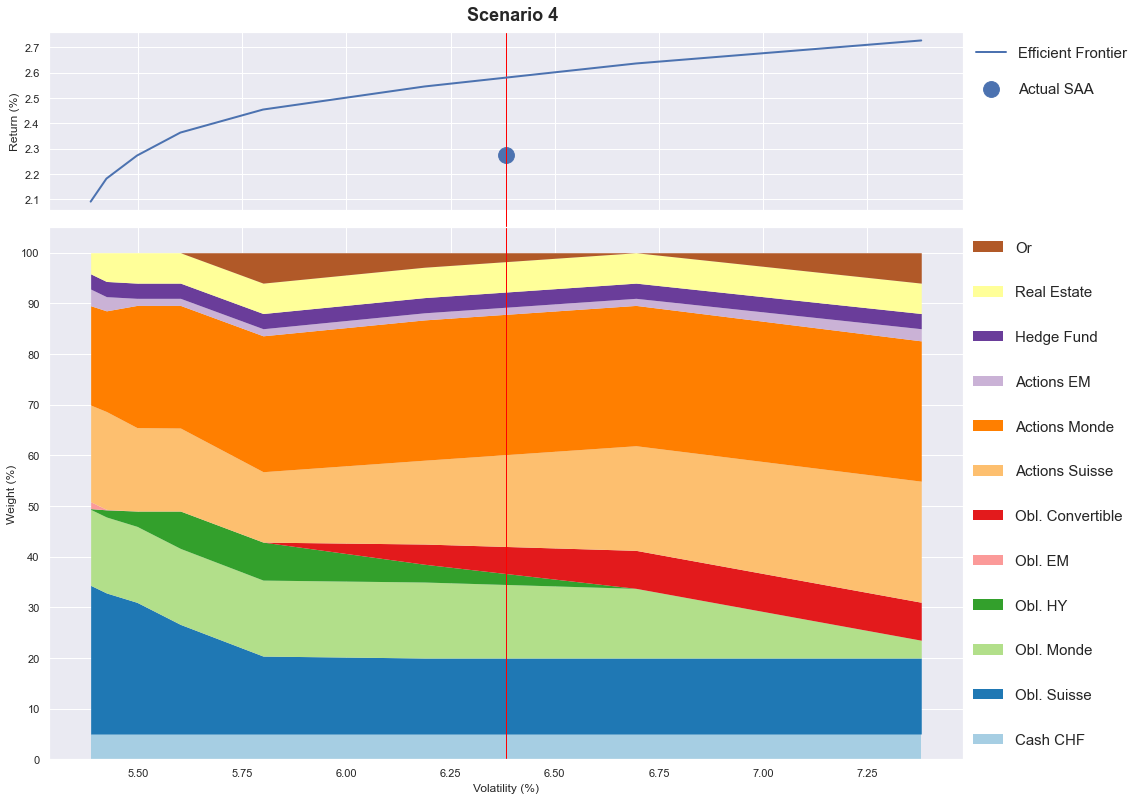

 21%|██        | 21/100 [00:00<00:01, 65.85it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


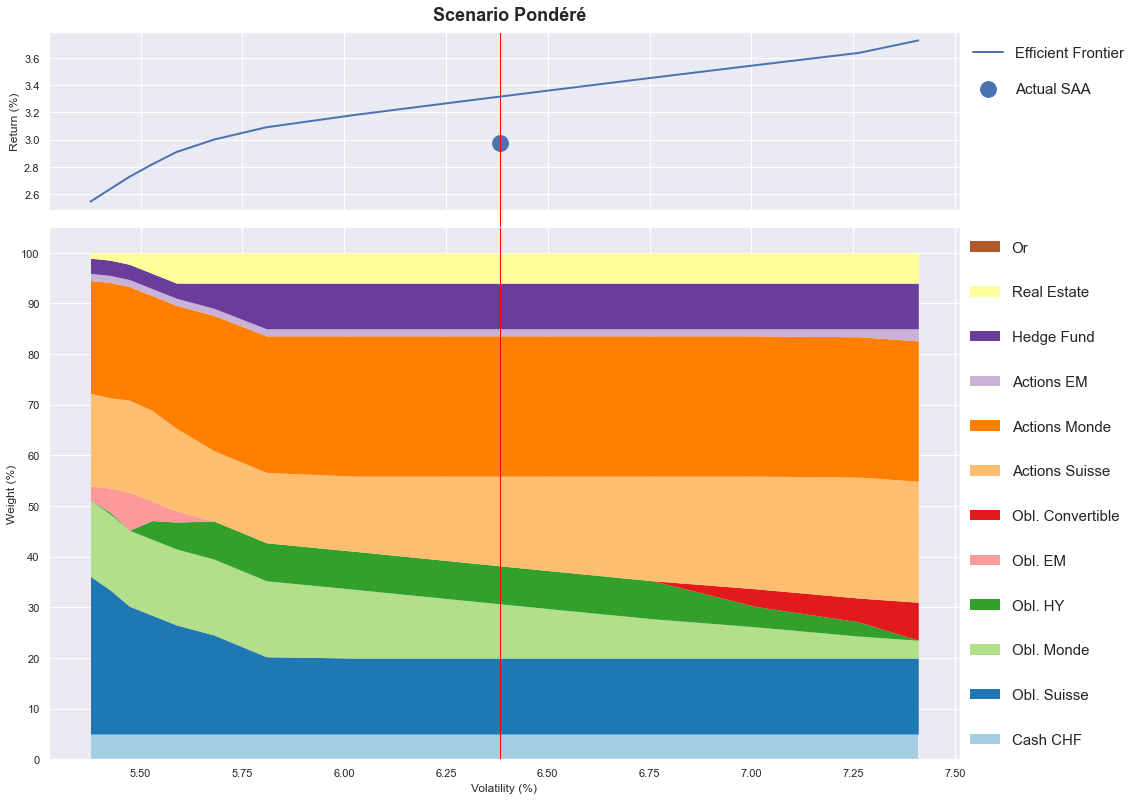

In [24]:
scenarios = list(df_scenarios.columns)
df_vol_all = pd.DataFrame()
dict_vol_all = {}
dict_weight_all = {}
dict_saa_all = {}

for i, scen in enumerate(scenarios):
    annual_returns = df_scenarios[scen].values
    
    # Optimisation
    opti_vol = []
    ret_min = 0.01
    ret_max = 0.10
    ret_grid = np.linspace(ret_min, ret_max, 100)
    opti_weight=[]
    x0 = np.array(saa.weight)
    for ret in tqdm(ret_grid):
        results = efficientOpt(x0, annual_returns, annual_cov_histo, ret, 
                               A=A, a_inf=a_inf, a_sup=a_sup, B=B, b_inf=b_inf, b_sup=b_sup, bounds=bounds)
        opti_vol.append(results['fun'])
        opti_weight.append(results['x'])

    opti_vol = 100 * np.array(opti_vol)
    ret_grid = 100 * np.array(ret_grid)
    opti_weight = np.array(opti_weight)
    opti_weight = opti_weight.round(4)

    df_vol = pd.DataFrame(data=zip(opti_vol, ret_grid), columns=['vol', 'ret'])
    df_vol['scenario'] = 'Scenario ' + str(scen)
    df_vol = df_vol[df_vol.vol.diff() > 0.01]
    df_vol = df_vol.round(4).drop_duplicates(subset=('vol'))
    df_vol = df_vol.iloc[1:]
    
    dict_vol_all[scen] = df_vol
    df_vol_all = pd.concat([df_vol_all, df_vol])
    
    df_opti_weight = pd.DataFrame(data=opti_weight, columns=list_isin)
    df_opti_weight = df_opti_weight.reindex(df_vol.index)
    df_opti_weight.index = df_vol[df_vol.columns[0]]
    df_opti_weight = df_opti_weight.sort_index()
    df_opti_weight.columns = list_nom
    df_opti_weight.fillna(0, inplace=True)

    dict_weight_all[scen] = df_opti_weight
    asset_opti = []
    group_matrix = np.array([ [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])

    list_asset = ['Liquidité', 'Obligations', 'Obligations à risque', 'Actions', 'Alternatifs']

    for i in range(len(df_opti_weight)):
        asset_opti.append(group_matrix @ df_opti_weight.iloc[i].values)
    asset_opti = np.array(asset_opti)
    
    port_ret, port_vol = 100 * portfolioReturn(saa.weight, annual_returns, annual_cov_histo), \
                         100 * portfolioVariance(saa.weight, annual_returns, annual_cov_histo)
    
    dict_saa_all[scen] = port_vol
    
    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(16,12), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
    axs = axs.ravel()
    palette_indices = sns.color_palette('Paired', n_colors=len(list_nom))
    palette_asset = sns.color_palette('hls', n_colors=len(list_asset))

    sns.lineplot(ax=axs[0], data=df_vol, x='vol', y='ret', sort=False, lw=2, palette="flare", label='Efficient Frontier')
    axs[0].scatter(x=port_vol, y=port_ret, s=250, label='Actual SAA')
    handles0, labels0 = axs[0].get_legend_handles_labels()
    lgd0 = axs[0].legend(handles0, labels0, bbox_to_anchor = (1, 1), fontsize=15, labelspacing=1.5, frameon=False)
    axs[0].grid(visible=True)
    axs[0].axvline(x=port_vol , ymin=-1.2, ymax=1, c="red",linewidth=1, zorder=1, clip_on=False)
    axs[0].set_ylabel('Return (%)', fontsize=12)

    axs[1].stackplot(df_opti_weight.index, 100 * df_opti_weight.values.T, labels=list_nom, colors=palette_indices, linewidth=0)
    handles1, labels1 = axs[1].get_legend_handles_labels()
    lgd1 = axs[1].legend(reversed(handles1), reversed(labels1), bbox_to_anchor = (1.19, 1), fontsize=15, labelspacing=2.05, frameon=False)
    axs[1].grid(visible=True)
    axs[1].axvline(x=port_vol ,ymin=0, ymax=1.2, c="red", linewidth=1, zorder=1, clip_on=False)
    axs[1].set_ylabel('Weight (%)', fontsize=12)
    axs[1].set_xlabel('Volatility (%)', fontsize=12)
    axs[1].locator_params(nbins=15, axis='y')

    #axs[2].stackplot(df_opti_weight.index, 100 * asset_opti.T, labels=list_asset, colors=palette_asset)
    #handles2, labels2 = axs[2].get_legend_handles_labels()
    #lgd = axs[2].legend(reversed(handles2), reversed(labels2), bbox_to_anchor = (1.182, 1), fontsize=12)
    #axs[2].axvline(x=port_vol ,ymin=0, ymax=1.2, c="red", linewidth=1, zorder=1, clip_on=False)
    #axs[2].grid()
    #axs[2].set_xlabel('Volatility (%)', fontsize=12)
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.05, top=0.95)
    title = 'Scenario ' + str(scen)
    fig.suptitle(title, fontsize=18, fontweight='bold', x=0.45)
    
    path = 'output/opti/indice_alloc_scenario_' + str(scen) + '.png'
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

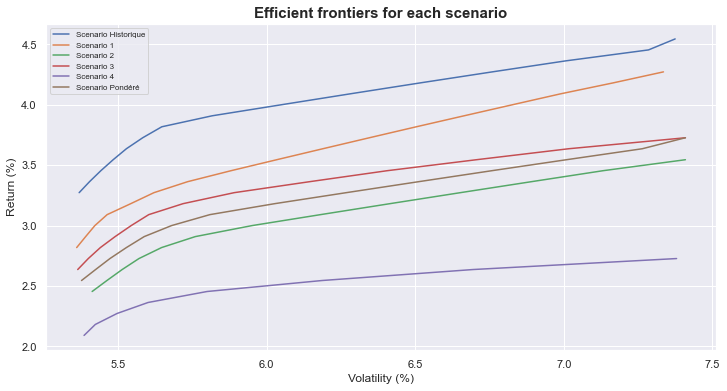

In [25]:
fig, ax =plt.subplots(figsize=(12,6))
for scen in scenarios:
    style = '-'
    if scen == 'Equal Weighted':
        style = '--'
    sns.lineplot(data=dict_vol_all[scen], x='vol', y='ret', label='Scenario ' + str(scen), linestyle=style)
plt.legend(fontsize=8)
plt.xlabel('Volatility (%)')
plt.ylabel('Return (%)')
plt.title('Efficient frontiers for each scenario', fontweight='bold', fontsize=15)
plt.grid(visible=True)
plt.savefig('output/opti/mpt_comparison.png', dpi=300, bbox_inches='tight')

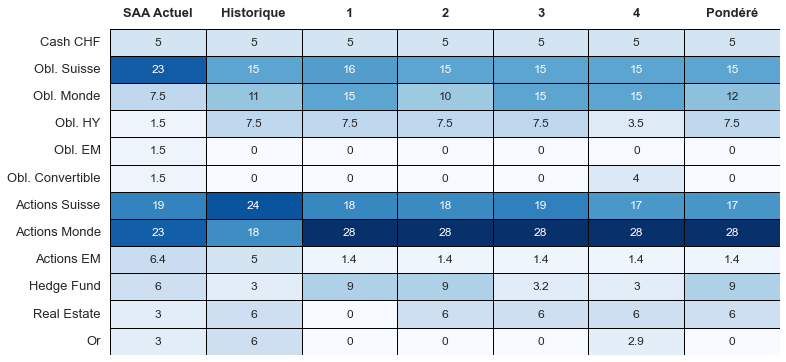

In [26]:
df_opti_resume = pd.DataFrame(index=list_nom, columns=['SAA Actuel'] + scenarios)
df_opti_resume['SAA Actuel'] = saa.weight.values
for scen in scenarios:
    port_vol = dict_saa_all[scen]
    df_opti_weight = dict_weight_all[scen]
    idx = df_opti_weight.reset_index()['vol'].sub(port_vol).abs().idxmin()
    df_opti_resume[scen] = df_opti_weight.iloc[idx].values
df_opti_resume = (df_opti_resume * 100).round(1)

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(data=df_opti_resume, annot=True, cmap='Blues', cbar=False, linewidths=1, linecolor='black')
ax.tick_params(axis='both', which='major', labelsize=13, labelbottom=False, labeltop=True)
plt.xticks(weight='bold')

plt.savefig('output/opti/weight_resume.png', dpi=300, bbox_inches='tight')
plt.show()